# 1. Подготовка данных

### осмотр данных

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
df = pd.read_csv('проект data.csv', delimiter=',', encoding='windows-1251')
df['DateTime'] = pd.to_datetime(df['DateTime'])  # Преобразование строки в datetime
print(df.head(5))
print("\nИнформация о данных:")
print(df.info(5))
print("\nСтатистика:")
print(df.describe().round(2))

             DateTime  stage_1_output_konv_avd  stage_2_input_water_sum  \
0 2021-01-28 18:00:00                    67.83                    92.99   
1 2021-01-28 19:00:00                    67.83                    91.82   
2 2021-01-28 20:00:00                    67.83                    90.65   
3 2021-01-28 21:00:00                    67.93                    90.24   
4 2021-01-28 22:00:00                    68.03                    89.84   

   stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
0                          474.18                       76.84   
1                          473.68                       76.15   
2                          473.17                       75.46   
3                          473.59                       75.26   
4                          474.00                       75.06   

   stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
0                                 97.52                         49.94   
1           

### 2. Обработка пропусков

In [65]:
# Удаление строк, где нет целевой переменной (danger_gas)
df = df.dropna(subset=['stage_4_output_danger_gas'])

# Функция для проверки всех видов пропуско
def is_missing(x):
    return pd.isna(x) | (x == "") | (x == " ") | (x is None)

# Подсчёт всех пропусков по столбцам
missing_values = df.apply(lambda col: col.apply(is_missing).sum())
print(missing_values)



DateTime                                 0
stage_1_output_konv_avd                 12
stage_2_input_water_sum                 15
stage_2_output_bottom_pressure          18
stage_2_output_bottom_temp               8
stage_2_output_bottom_temp_hum_steam     4
stage_2_output_bottom_vacuum            24
stage_2_output_top_pressure              4
stage_2_output_top_pressure_at_end       1
stage_2_output_top_temp                  9
stage_2_output_top_vacuum               10
stage_3_input_pressure                  17
stage_3_input_soft_water                10
stage_3_input_steam                      1
stage_3_output_temp_hum_steam            2
stage_3_output_temp_top                 14
stage_4_input_overheated_steam           2
stage_4_input_polymer                   10
stage_4_input_steam                     26
stage_4_input_water                     21
stage_4_output_danger_gas                0
stage_4_output_dry_residue_avg           0
stage_4_output_product                   0
work_shift 

In [66]:
# Заполнение пропусков (медианой или интерполяцией)
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Проверка, что пропусков нет
print("\nПропуски после обработки:")
print(df.isnull().sum().sum())  # Должно быть 0


Пропуски после обработки:
0


### 3. Обработка выбросов

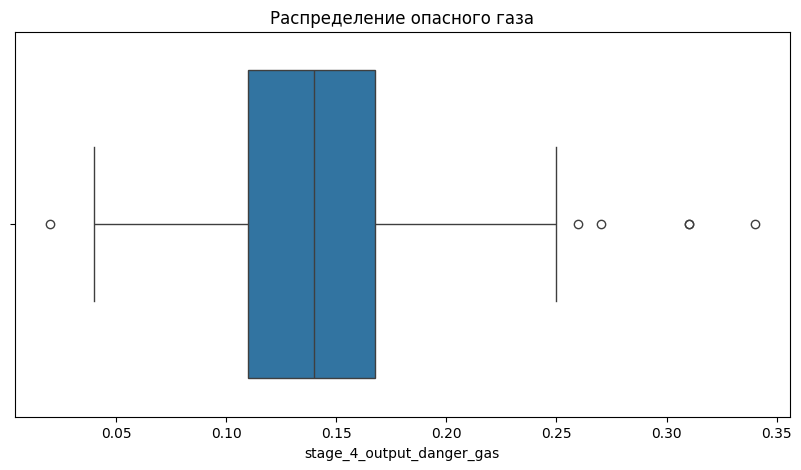

Осталось данных после удаления выбросов: 928


In [67]:
# Визуализация выбросов для danger_gas
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['stage_4_output_danger_gas'])
plt.title("Распределение опасного газа")
plt.show()

# Удаление выбросов (например, по IQR)
Q1 = df['stage_4_output_danger_gas'].quantile(0.25)
Q3 = df['stage_4_output_danger_gas'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['stage_4_output_danger_gas'] >= lower_bound) & 
        (df['stage_4_output_danger_gas'] <= upper_bound)]

print(f"Осталось данных после удаления выбросов: {len(df)}")

### создание новых признаков)

In [68]:
# Временные признаки
df['hour'] = df['DateTime'].dt.hour
df['day_of_week'] = df['DateTime'].dt.dayofweek  # 0-понедельник, 6-воскресенье

# Лаговые признаки (значения на предыдущем шаге)
df['stage_2_temp_lag1'] = df['stage_2_output_bottom_temp'].shift(1)
df['stage_3_pressure_lag1'] = df['stage_3_input_pressure'].shift(1)

# Скользящее среднее (например, давление за последние 3 часа)
df['stage_2_pressure_rolling_mean'] = df['stage_2_output_bottom_pressure'].rolling(window=3).mean()

# Удаление строк с NaN после создания лагов
df = df.dropna()

print("\nНовые признаки:")
print(df[['DateTime', 'hour', 'day_of_week', 'stage_2_temp_lag1', 'stage_2_pressure_rolling_mean']].head())


Новые признаки:
              DateTime  hour  day_of_week  stage_2_temp_lag1  \
14 2021-01-29 08:00:00     8            4              76.90   
20 2021-01-29 21:00:00    21            4              76.74   
24 2021-01-30 01:00:00     1            5              75.31   
25 2021-01-30 21:00:00    21            5              77.53   
28 2021-01-31 00:00:00     0            6              81.34   

    stage_2_pressure_rolling_mean  
14                     473.386667  
20                     470.796667  
24                     468.586667  
25                     470.510000  
28                     474.746667  


### 5. Разделение данных на train/test

In [69]:
from sklearn.model_selection import train_test_split

# Выбор признаков и целевой переменной
features = [
    'stage_1_output_konv_avd',
    'stage_2_output_bottom_temp',
    'stage_2_output_top_pressure',
    'stage_3_input_pressure',
    'stage_4_input_overheated_steam',
    'hour',
    'day_of_week',
    'stage_2_temp_lag1',
    'stage_2_pressure_rolling_mean'
]

X = df[features]
y = df['stage_4_output_danger_gas']

# Разделение данных (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTrain size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (740, 9), Test size: (186, 9)


### 6. Визуализация корреляции

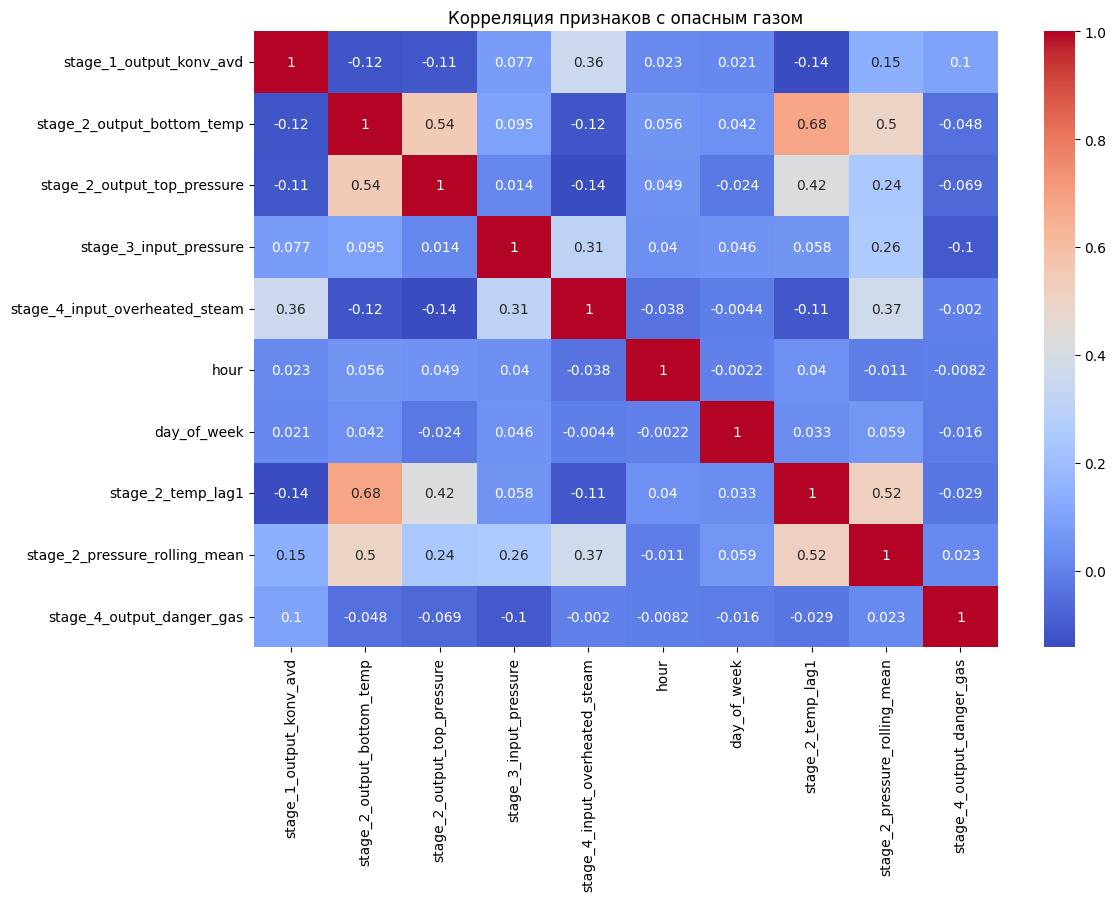

In [70]:
# Матрица корреляции
corr_matrix = df[features + ['stage_4_output_danger_gas']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Корреляция признаков с опасным газом")
plt.show()

# Этап 2: Разведочный анализ и предварительное моделирование

### 1. Анализ распределения целевой переменной

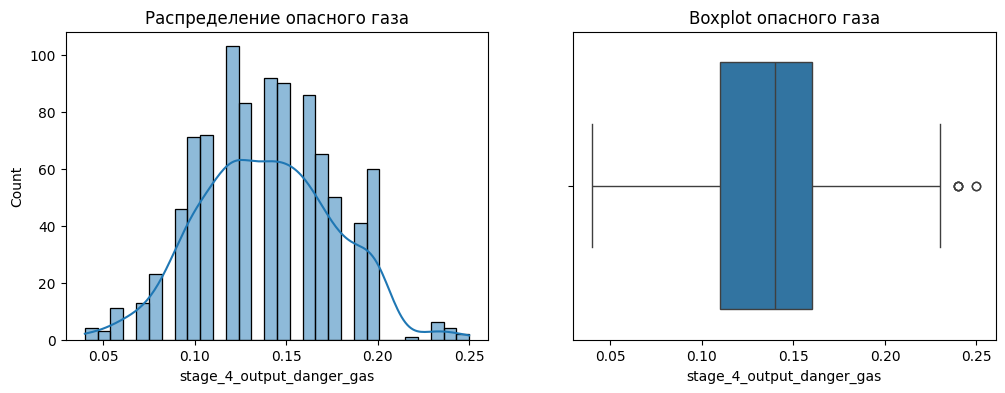

In [71]:
# Гистограмма и boxplot для danger_gas
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['stage_4_output_danger_gas'], bins=30, kde=True)
plt.title('Распределение опасного газа')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['stage_4_output_danger_gas'])
plt.title('Boxplot опасного газа')
plt.show()

### 2. Анализ корреляций

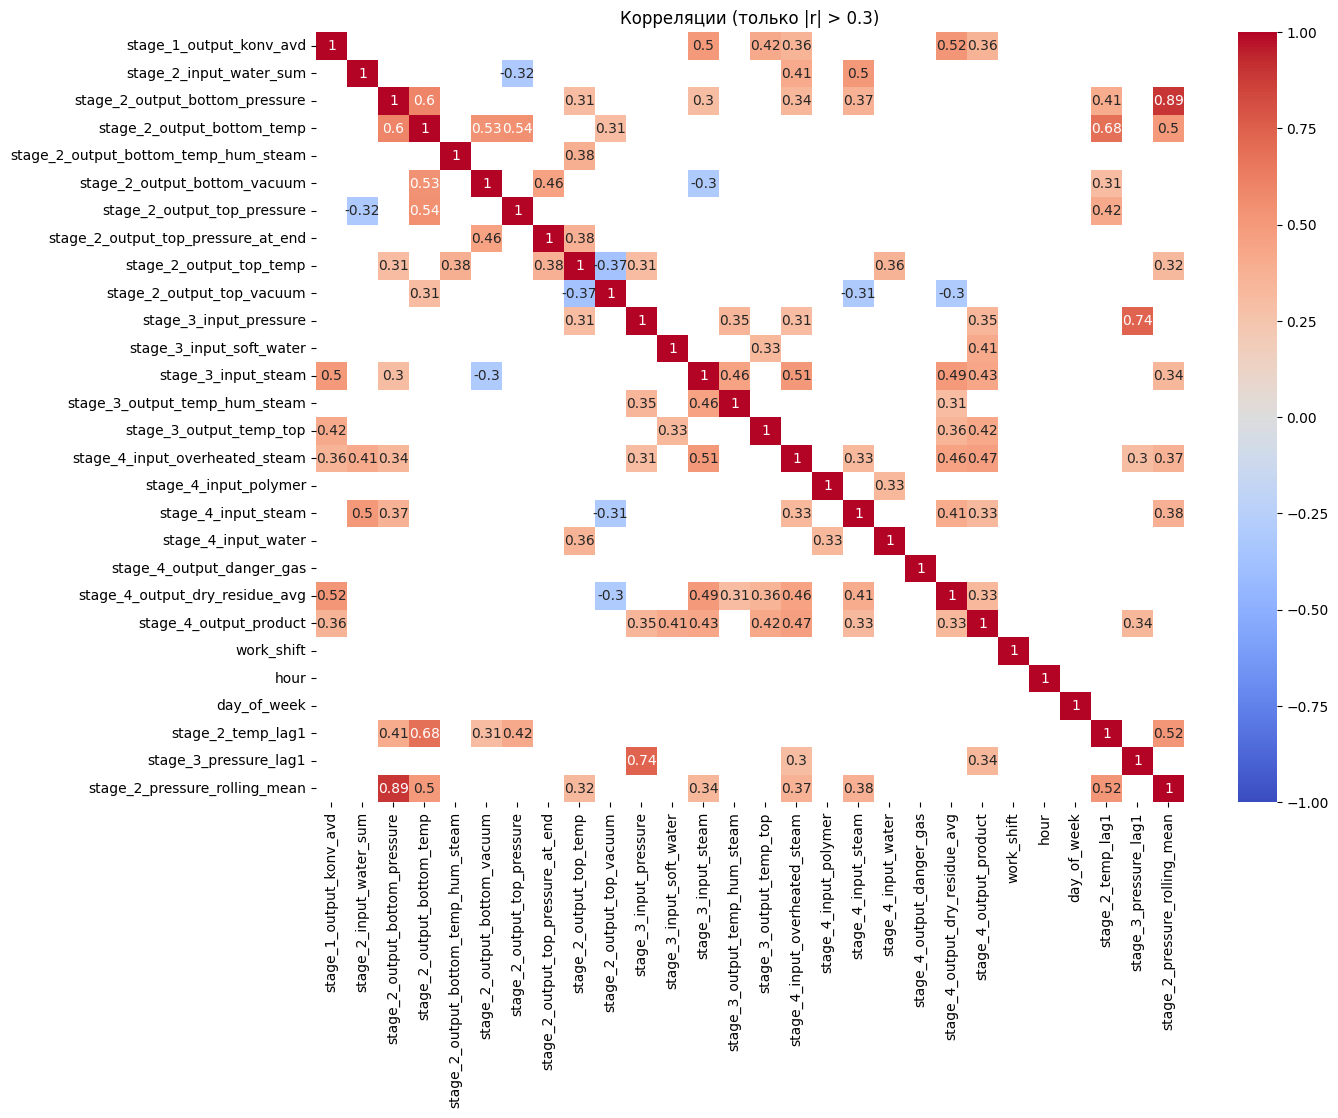

In [72]:
# Тепловая карта корреляций
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix[(corr_matrix > 0.3) | (corr_matrix < -0.3)], 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляции (только |r| > 0.3)')
plt.show()

### 3. Анализ временных трендов

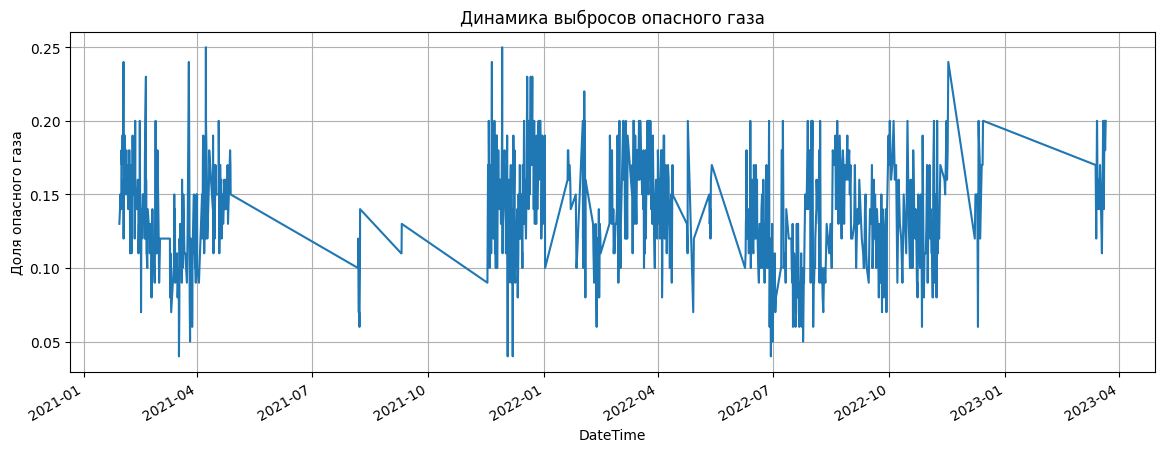

In [73]:
# Динамика выбросов по времени
plt.figure(figsize=(14, 5))
df.set_index('DateTime')['stage_4_output_danger_gas'].plot()
plt.title('Динамика выбросов опасного газа')
plt.ylabel('Доля опасного газа')
plt.grid()
plt.show()

### 4. Зависимость выбросов от смены (work_shift)

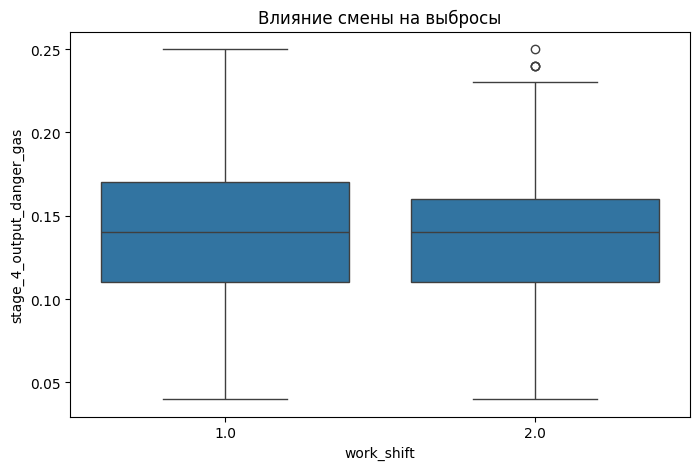

In [74]:
# Boxplot по сменам
plt.figure(figsize=(8, 5))
sns.boxplot(x='work_shift', y='stage_4_output_danger_gas', data=df)
plt.title('Влияние смены на выбросы')
plt.show()

### 5. Предварительное моделирование (линейная регрессия)

R2: 0.002
MAE: 0.030


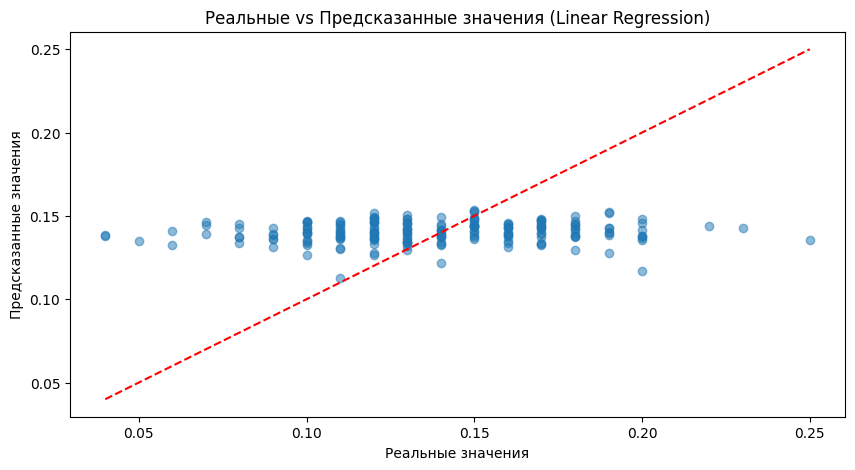

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Выбор признаков и разбиение данных
features = [
    'stage_1_output_konv_avd',
    'stage_2_output_bottom_temp',
    'stage_2_output_top_pressure',
    'stage_3_input_pressure',
    'stage_4_input_overheated_steam',
    'hour',
    'day_of_week'
]

X = df[features]
y = df['stage_4_output_danger_gas']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказание и оценка
y_pred = model.predict(X_test)
print(f"R2: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")

# Визуализация предсказаний
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title('Реальные vs Предсказанные значения (Linear Regression)')
plt.show()

### 6. Важность признаков

In [76]:
# Коэффициенты линейной регрессии
coefs = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
coefs = coefs.sort_values('Coefficient', key=abs, ascending=False)
print("\nВажность признаков:")
print(coefs)


Важность признаков:
                          Feature  Coefficient
3          stage_3_input_pressure    -0.069701
0         stage_1_output_konv_avd     0.001016
1      stage_2_output_bottom_temp     0.000465
6                     day_of_week    -0.000367
5                            hour    -0.000138
2     stage_2_output_top_pressure    -0.000039
4  stage_4_input_overheated_steam    -0.000004
